<a href="https://colab.research.google.com/github/Ognezvezdd/PySynthesizer/blob/master/FGPAv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка и чтение данных

Импорт модулей

In [ ]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import librosa
import shutil
import os
import resampy
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

Загрузка архива данных из kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dauletzhamanbaev","key":"193af3c752d6f93e2aa527a1ee91aa8d"}'}

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c freesound-audio-tagging

100% 7.05G/7.05G [01:15<00:00, 156MB/s]
100% 7.05G/7.05G [01:15<00:00, 100MB/s]


Распаковка архива

In [ ]:
import zipfile

with zipfile.ZipFile("freesound-audio-tagging.zip", "r") as zip_ref:
    zip_ref.extractall()


Чтение данных

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("sample_submission.csv")

##Знакомство с данными

In [ ]:
train

fname         label  manually_verified
0     00044347.wav        Hi-hat                  0
1     001ca53d.wav     Saxophone                  1
2     002d256b.wav       Trumpet                  0
3     0033e230.wav  Glockenspiel                  1
4     00353774.wav         Cello                  1
...            ...           ...                ...
9468  ffec59fb.wav     Fireworks                  0
9469  fff37590.wav        Hi-hat                  0
9470  fff44ac6.wav      Laughter                  0
9471  fff6a13d.wav         Chime                  0
9472  fff81f55.wav         Cough                  1

[9473 rows x 3 columns]

Данный датасет содержит 3 признака:
* fname - представляет наименование записи(звука)
* label - представляет категорию к которой относится запись звука
* manually_verified - представляет признак, указывающий, была ли метка класса проверена вручную или автоматически.

Целевым признаком данной модели является признак label



In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9473 entries, 0 to 9472
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fname              9473 non-null   object
 1   label              9473 non-null   object
 2   manually_verified  9473 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 222.1+ KB


In [ ]:
train.describe()

manually_verified
count        9473.000000
mean            0.391639
std             0.488143
min             0.000000
25%             0.000000
50%             0.000000
75%             1.000000
max             1.000000

In [ ]:
n_test = test.shape[0]
n_training = train.shape[0]
n_categories = len(train.label.unique())

print(f"Количество обучающих примеров: {n_training}")
print(f"Количество тестовых примеров: {n_test}")
print(f"Количество уникальных категорий: {n_categories}\n")

print(train.label.unique())

Количество обучающих примеров: 9473
Количество тестовых примеров: 9400
Количество уникальных категорий: 41

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


Распределение ручной и автоматической проверки.


<Axes: xlabel='manually_verified', ylabel='count'>

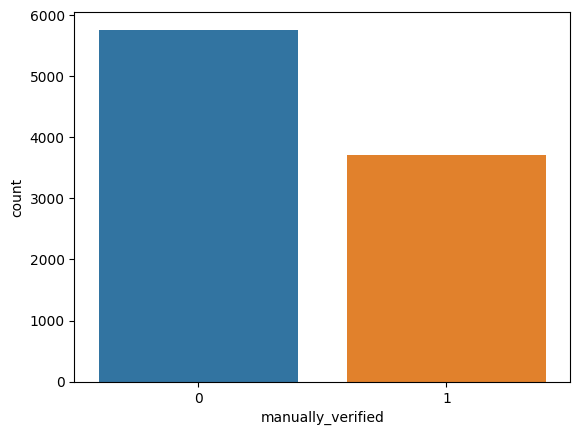

In [ ]:
sns.countplot(data = train, x = "manually_verified")

Распределение категорий (label)

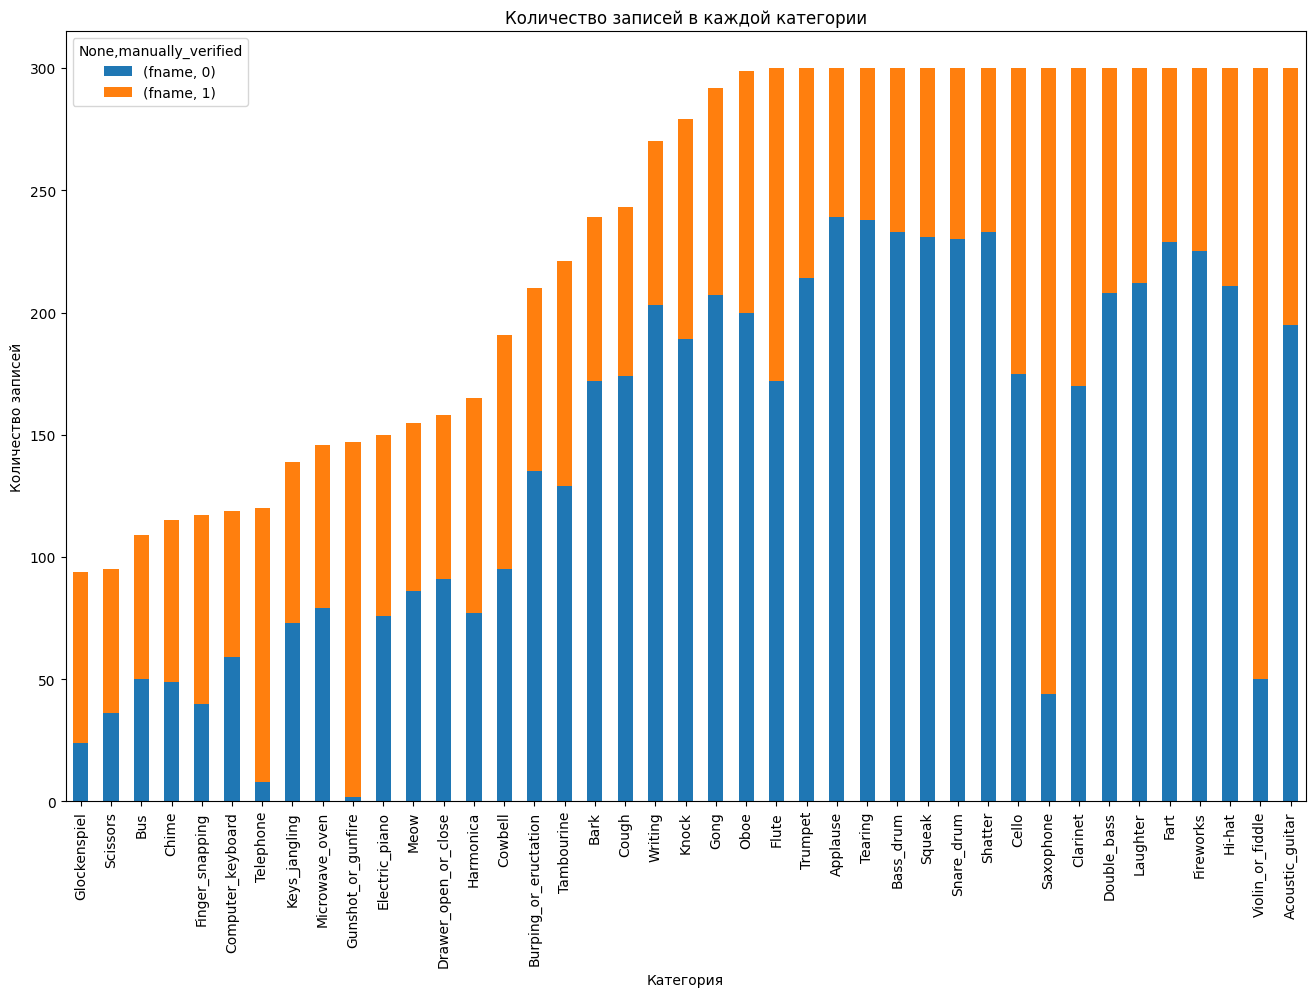

In [ ]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Количество записей в каждой категории", figsize=(16,10))
plot.set_xlabel("Категория")
plot.set_ylabel("Количество записей");

In [ ]:
print('Минимальное количество записей = ', min(train.label.value_counts()))
print('Максимальное количество записей = ', max(train.label.value_counts()))

Минимальное количество записей =  94
Максимальное количество записей =  300


Можем прийти к следующим выводам:

*   Количество аудиообразцов (записей) в каждой категории не является одинаковым. Минимальное количество аудиообразцов в одной категории составляет 94, а максимальное - 300. Это указывает на неравномерное распределение аудиоданных по категориям.
*   Пропорция аудиозаписей, подтвержденных вручную (manually_verified), также неоднородна в разных категориях. В некоторых категориях больше подтвержденных аудиозаписей, чем в других.



##Анализ аудиофайлов

Аудиофайлы используют формат PCM c 16-битной глубиной кодирования звука и частотой дискретизации 44.1 кГц

In [ ]:
import IPython.display as ipd
fname = 'audio_train/' + '00044347.wav'
ipd.Audio(fname)

In [ ]:
import wave
wav = wave.open(fname)
print("Частота дискретизации = ", wav.getframerate())
print("Общее количество аудиофреймов = ", wav.getnframes())
print("Длительность = ", wav.getnframes()/wav.getframerate())

Частота дискретизации =  44100
Общее количество аудиофреймов =  617400
Длительность =  14.0


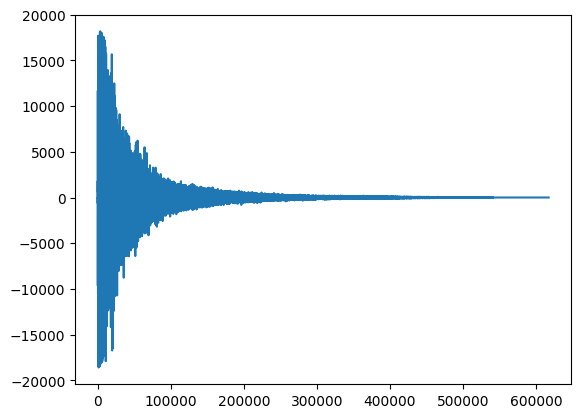

In [ ]:
from scipy.io import wavfile
rate, data = wavfile.read(fname)
plt.plot(data, '-', );

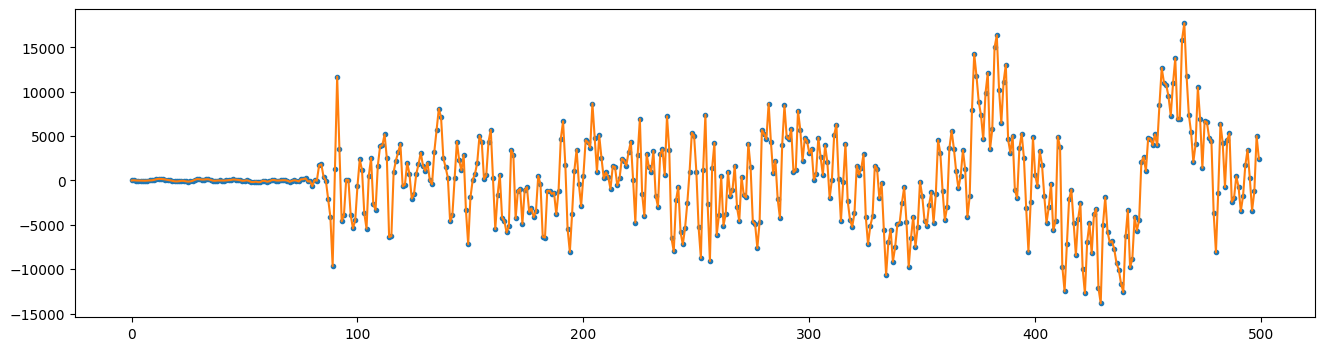

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

Анализ длины звуков

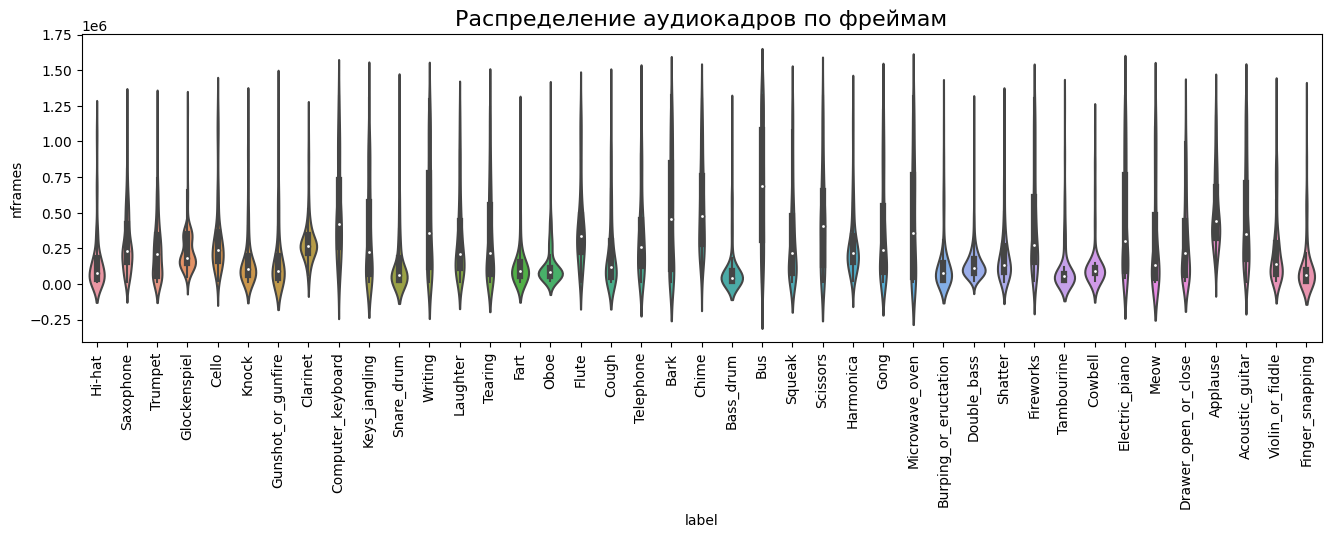

In [ ]:
train['nframes'] = train['fname'].apply(lambda f: wave.open('audio_train/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('audio_test/' + f).getnframes())

_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train)
plt.xticks(rotation=90)
plt.title('Распределение аудиокадров по фреймам', fontsize=16)
plt.show()

Таким образом, распределение длины аудиофайлов в разных категориях (метках) неоднородно и имеет высокую вариацию. Аудиофайлы в разных категориях имеют различные длительности и разброс значений длительности внутри каждой категории велик.

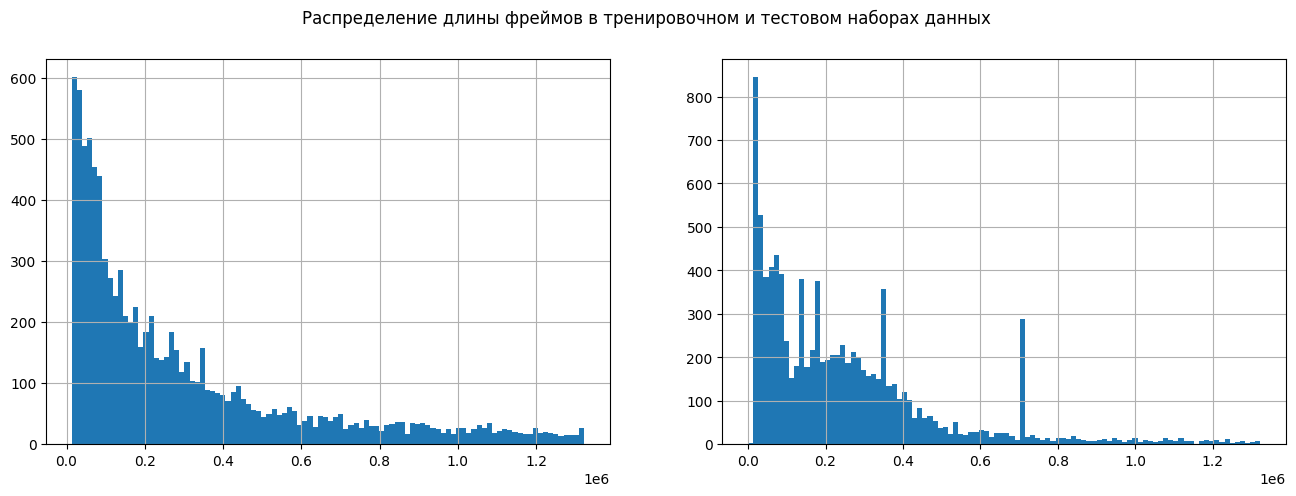

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
train.nframes.hist(bins=100, ax=axes[0])
test.nframes.hist(bins=100, ax=axes[1])
plt.suptitle('Распределение длины фреймов в тренировочном и тестовом наборах данных', ha='center', fontsize='large');

Приходим к выводу, что большинство аудиофайлов являются короткими.  Однако также есть четыре аномальных значения длины в тестовом наборе данных, которые отличаются от типичного распределения.

In [ ]:
!pip install ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.9 MB/s eta 0:00:00


In [ ]:
import IPython

abnormal_length = [707364, 353682, 138474, 184338]

for length in abnormal_length:
    abnormal_fnames = test.loc[test.nframes == length, 'fname'].values
    print("Frame length =", length, "Number of files =", abnormal_fnames.shape[0], end="   ")
    fname = np.random.choice(abnormal_fnames)
    print("Playing", fname)
    IPython.display.display(ipd.Audio('audio_test/' + fname))

Frame length = 707364 Number of files = 210   Playing 9e6112ee.wav


Frame length = 353682 Number of files = 127   Playing 84e18e10.wav


Frame length = 138474 Number of files = 170   Playing f17d7d55.wav


Frame length = 184338 Number of files = 153   Playing 3bed0356.wav


##Предварительная обработка данных

Устанавливаем частоту дискретизации, удаляем пустые звуковые записи

In [ ]:
sampling_rate = 44100

test['toremove'] = 0
test.loc[test.fname.isin([
    '0b0427e2.wav', '6ea0099f.wav', 'b39975f5.wav'
]), 'toremove'] = 1

Удаляем "тишину" в начале и конце каждого аудиофайла в обучающей и тестовой выборке. Сохраняем обработанные файлы в формате NumPy

In [ ]:
print('Train...')
os.makedirs('audio_train_trim', exist_ok=True)
for filename in tqdm(train.fname.values):
    x, sr = librosa.load('audio_train/' + filename, sr = sampling_rate)
    x = librosa.effects.trim(x)[0]
    np.save('audio_train_trim/' + filename, x)

print('Test...')
os.makedirs('audio_test_trim', exist_ok=True)
for filename in tqdm(test.loc[lambda x: x.toremove == 0, :].fname.values):
    x, sr = librosa.load('audio_test/' + filename, sr = sampling_rate)
    x = librosa.effects.trim(x)[0]
    np.save('audio_test_trim/' + filename, x)

In [ ]:
import soundfile as sf

print('Train...')
os.makedirs('audio_train_trim_wav', exist_ok=True)
for filename in tqdm(train.fname.values):
    x, sr = librosa.load('audio_train/' + filename, sr=sampling_rate)
    x = librosa.effects.trim(x)[0]
    sf.write('audio_train_trim_wav/' + filename[:-4] + '.wav', x, sr)

print('Test...')
os.makedirs('audio_test_trim_wav', exist_ok=True)
for filename in tqdm(test.loc[lambda x: x.toremove == 0, :].fname.values):
    x, sr = librosa.load('audio_test/' + filename, sr=sampling_rate)
    x = librosa.effects.trim(x)[0]
    sf.write('audio_test_trim_wav/' + filename[:-4] + '.wav', x, sr)

Train...


100%|██████████| 9473/9473 [08:40<00:00, 18.20it/s]


Test...


100%|██████████| 9397/9397 [06:14<00:00, 25.10it/s]


##Построение модели с использованием необработанного звука (1D массив)


In [ ]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D,
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

AttributeError: ignored

Настройки

In [ ]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001,
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate #Частота дискретизации
        self.audio_duration = audio_duration # Длительность аудио
        self.n_classes = n_classes # Количество категорий
        self.use_mfcc = use_mfcc # Использование MFCC(Мел-частотные кепстральные коэффициенты)
        self.n_mfcc = n_mfcc # Количество MFCC коэффициентов
        self.n_folds = n_folds # Количество фолдов(складок)
        self.learning_rate = learning_rate #Скорость обучения
        self.max_epochs = max_epochs #Максимальное количество эпох. Сколько раз модель будет просматривать весь обучающий набор данных

        self.audio_length = self.sampling_rate * self.audio_duration #Количество выборок в аудио клипе
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

Генерация данных во время обучения модели

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None, #Конструктор
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size)) #Количество пакетов данных

    def __getitem__(self, index): #Возвращает пакет данных с определенным индексом
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self): # Перемешивает индексы для случайного использования данных на каждой эпохе
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp): #Генерирует пакет данных
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID

            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X




In [ ]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

In [ ]:
def get_1d_dummy_model(config):

    nclass = config.n_classes
    input_length = config.audio_length

    inp = Input(shape=(input_length,1))
    x = GlobalMaxPool1D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

def get_1d_conv_model(config):

    nclass = config.n_classes
    input_length = config.audio_length

    inp = Input(shape=(input_length,1))
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)

    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)

    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)

    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)
    x = Dense(1028, activation=relu)(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model



In [ ]:
!pip install scikit-learn

In [ ]:
train.columns

Index(['label', 'manually_verified', 'label_idx'], dtype='object')

In [ ]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])
config = Config(sampling_rate=16000, audio_duration=2, n_folds=10, learning_rate=0.001)

In [ ]:
from sklearn.model_selection import StratifiedKFold
import shutil

PREDICTION_FOLDER = "predictions_1d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(n_splits=config.n_folds)

for i, (train_split, val_split) in enumerate(skf.split(train, train.label_idx)):
    train_set = train.iloc[train_split]
    val_set = train.iloc[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

    callbacks_list = [checkpoint, early, tb]
    print("Fold: ", i)
    print("#"*50)
    model = get_1d_conv_model(config)

    train_generator = DataGenerator(config, 'audio_train_trim_wav/', train_set.index,
                                    train_set.label_idx, batch_size=64,
                                    preprocessing_fn=audio_norm)
    val_generator = DataGenerator(config, 'audio_train_trim_wav/', val_set.index,
                                  val_set.label_idx, batch_size=64,
                                  preprocessing_fn=audio_norm)

    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=config.max_epochs, use_multiprocessing=True, workers=6, max_queue_size=20)

    model.load_weights('best_%d.h5'%i)

    # Save train predictions
    train_generator = DataGenerator(config, 'audio_train_trim_wav/', train.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(train_generator, use_multiprocessing=True,
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    test_generator = DataGenerator(config, 'audio_test_trim_wav/', test.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(test_generator, use_multiprocessing=True,
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)

Fold:  0
##################################################


<ipython-input-33-98f1ef6422da>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,


Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 3.3642 - acc: 0.0826
Epoch 1: val_loss improved from inf to 2.95814, saving model to best_0.h5
134/134 [==============================] - 1402s 10s/step - loss: 3.3642 - acc: 0.0826 - val_loss: 2.9581 - val_acc: 0.1456
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 2.8709 - acc: 0.1798
Epoch 2: val_loss improved from 2.95814 to 2.70733, saving model to best_0.h5
134/134 [==============================] - 1454s 10s/step - loss: 2.8709 - acc: 0.1798 - val_loss: 2.7073 - val_acc: 0.2257
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: 2.6685 - acc: 0.2353
Epoch 3: val_loss improved from 2.70733 to 2.59471, saving model to best_0.h5
134/134 [==============================] - 1438s 10s/step - loss: 2.6685 - acc: 0.2353 - val_loss: 2.5947 - val_acc: 0.2605
Epoch 4/50
134/134 [==============================] - ETA: 0s - loss: 2.5045 - acc: 0.2773
Epoch 4: val_loss improved from 2.

##Построение модели с использованием MFCC

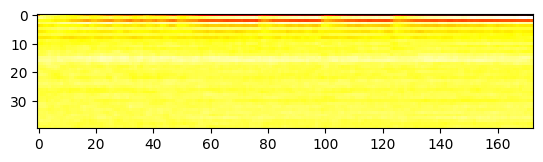

In [ ]:
SAMPLE_RATE = 44100
fname = 'audio_train_trim_wav/' + '00044347.wav'   # Hi-hat
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]
mfcc = librosa.feature.mfcc(y = wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

In [ ]:
!pip install tensorflow
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.4 MB/s eta 0:00:00
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)


In [ ]:
import tensorflow as tf
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.12.0
Keras version: 2.12.0


In [ ]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, BatchNormalization, Flatten, GlobalMaxPooling2D, MaxPooling2D, concatenate, Activation
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import backend as K


In [ ]:
def get_2d_dummy_model(config):

    nclass = config.n_classes

    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


def get_2d_conv_model(config):

    nclass = config.n_classes

    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Conv2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)

    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)

    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)

    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

Подготовка данных

In [ ]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=10,
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
        file_path = data_dir + fname
        if not os.path.exists(file_path):
            print(f"{file_path} не существует")
            continue
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(y=data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X
X_train = prepare_data(train, config, 'audio_train_trim_wav/')
X_test = prepare_data(test, config, 'audio_test_trim_wav/')
y_train = to_categorical(train.label_idx, num_classes=config.n_classes)

audio_test_trim_wav/0b0427e2.wav не существует
audio_test_trim_wav/6ea0099f.wav не существует
audio_test_trim_wav/b39975f5.wav не существует


Нормализация

In [ ]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

Обучение

In [ ]:
print(y_train.shape)
print(X_train.shape)

(9473, 41)
(9473, 40, 173, 1)


In [ ]:
!pip install iterative-stratification

In [ ]:
from sklearn.model_selection import KFold
from keras.layers import Input
from keras.layers import Dense
from keras.activations import softmax
from keras import models, optimizers
from keras import losses

PREDICTION_FOLDER = "predictions_2d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

kf = KFold(n_splits=config.n_folds, shuffle=True, random_state=42)
for i, (train_split, val_split) in enumerate(kf.split(X_train, y_train)):
    K.clear_session()
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list,
                        batch_size=64, epochs=config.max_epochs)
    model.load_weights('best_%d.h5'%i)

    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)





##################################################
Fold:  0
Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 2.9499 - acc: 0.2191
Epoch 1: val_loss improved from inf to 3.37065, saving model to best_0.h5
134/134 [==============================] - 339s 2s/step - loss: 2.9499 - acc: 0.2191 - val_loss: 3.3707 - val_acc: 0.1540
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 2.2586 - acc: 0.3920
Epoch 2: val_loss improved from 3.37065 to 2.85497, saving model to best_0.h5
134/134 [==============================] - 324s 2s/step - loss: 2.2586 - acc: 0.3920 - val_loss: 2.8550 - val_acc: 0.2479
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: 1.8764 - acc: 0.4900
Epoch 3: val_loss improved from 2.85497 to 1.92995, saving model to best_0.h5
134/134 [==============================] - 327s 2s/step - loss: 1.8764 - acc: 0.4900 - val_loss: 1.9300 - val_acc: 0.4789
Epoch 4/50
134/134 [==============================] - ETA: 0s - loss: 1